In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
# from scipy import interpolate
import time
import pandas as pd
from func_flex import oracle_flex

In [2]:
np.set_printoptions(precision=6, suppress = True)
cp.installed_solvers()

perform_exp = True

## How to price flexibility?

In [3]:
np.tril(np.ones(3))@np.array([1,2,3]).T

array([1., 3., 6.])

In [4]:
steps = 5
price = np.array([2, 2, 1, 2, 2])
demand = np.array([10, 10, 10, 10, 10])
t = np.arange(steps)
naive_cost = np.sum(np.multiply(price, demand))
best_cost, Z = oracle_flex(price, demand, max_storage = 1, nonneg=True)
storage = np.cumsum(Z - demand)
print(f"{best_cost=}, {naive_cost=},\n {Z=},\n {storage=}")

best_cost=89.000149873764, naive_cost=90,
 Z=array([10.      , 10.      , 11.      ,  9.499967,  9.500033]),
 storage=array([ 0.      , -0.      ,  1.      ,  0.499967, -0.      ])


## Single Experiment

best_cost=4457.76, naive_cost=10081.67


(0, 15.00852900420322)

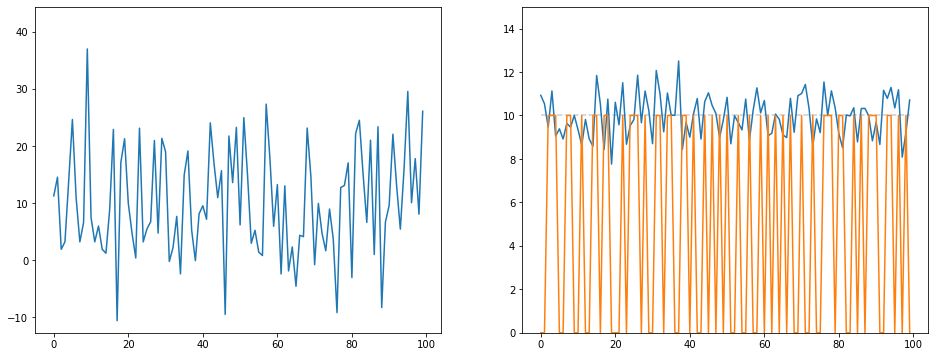

In [5]:
steps = 100 # Previously 25
price = np.random.normal(10, 10, steps) 
demand = np.random.normal(10, 1, steps)
#price = np.maximum(0, price)
demand = np.maximum(0, demand)
naive_cost = np.sum(np.multiply(price, demand))
t = np.arange(steps)

max_storage = 10
alpha = 2 * max_storage
best_cost, Z = oracle_flex(price, demand, max_storage = max_storage, nonneg = False, alpha = alpha)
storage = np.cumsum(Z - demand)
print(f"{best_cost=:.2f}, {naive_cost=:.2f}")

fig1 = plt.figure(figsize = (16,6))
ax1 = fig1.add_subplot(1,2,1)
ax2 = fig1.add_subplot(1,2,2)

ax1.plot(t, price)
ax2.plot(t, demand)
ax2.plot(t, storage)
ax2.hlines(max_storage, min(t), max(t), alpha = 0.2, ls="--")
#ax2.plot(t, Z)
ax1.set_ylim(min(0,min(price)*1.2), max(price)*1.2)
ax2.set_ylim(min(0,min(demand)*1.2), max(demand)*1.2)

## First experiment

In [6]:
def first_exp(muPrice, stdPrice, muDemand, stdDemand, alpha_coef = 0):
    l_maxStorage = []
    l_naiveCost = []
    l_bestCost = []
    l_savings = []
    l_installedStorage = []
    l_valueFlex = []
    
    steps = 100 # Previously 25
    for maxStorage in np.linspace(1, 1001, 10): #[1, 3, 10, 30, 100, 300, 1000]:
        for i in range(20):
            alpha = alpha_coef * maxStorage 
            price = np.random.normal(muPrice, stdPrice, steps) 
            demand = np.random.normal(muDemand, stdDemand, steps)
            demand = np.maximum(0, demand)
            best_cost, Z = oracle_flex(price, demand, max_storage = maxStorage, nonneg = False, alpha=alpha)
            
            naive_cost = np.sum(np.multiply(price, demand))
            storage = np.cumsum(Z - demand)
            installed_storage = max(storage)
            value_flex = (naive_cost - best_cost) / installed_storage
        
            l_maxStorage.append(maxStorage)
            l_naiveCost.append(naive_cost)
            l_bestCost.append(best_cost)
            l_savings.append(naive_cost - best_cost)
            l_installedStorage.append(installed_storage)
            l_valueFlex.append(value_flex)
    df_results = pd.DataFrame(data = np.array([l_maxStorage, l_naiveCost, l_bestCost, l_savings, l_installedStorage, l_valueFlex]).T,
    columns = ["maxStorage", "naiveCost", "bestCost", "savings", "installedStorage", "valueFlex"])

    gdf_results = df_results.groupby(by = ["maxStorage"]).agg(naiveCost_avg = ("naiveCost", np.mean),
                                                          naiveCost_std = ("naiveCost", np.std),
                                                          bestCost_avg = ("bestCost", np.mean),
                                                          bestCost_std = ("bestCost", np.std),
                                                          savings_avg = ("savings", np.mean),
                                                          savings_std = ("savings", np.std),
                                                          installedStorage_avg = ("installedStorage", np.mean),
                                                          installedStorage_std = ("installedStorage", np.std),
                                                          valueFlex_avg = ("valueFlex", np.mean),
                                                          valueFlex_std = ("valueFlex", np.std),
                                                         ).reset_index()
    gdf_results.head(200)  
    return gdf_results

[553.398712]
m: 553.40, b: 0.00 


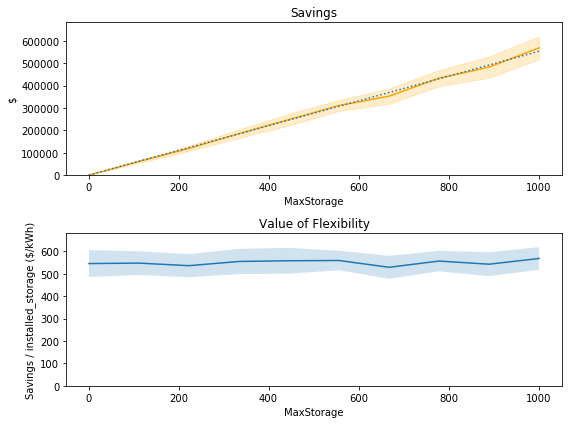

In [14]:
gdf_results = first_exp(100, 10, 100, 10, alpha_coef = 1)
fig1 = plt.figure(figsize=(8,6))

ax1 = fig1.add_subplot(2,1,1)
ax2 = fig1.add_subplot(2,1,2)

ax1.plot(gdf_results["maxStorage"], gdf_results["savings_avg"], color = "orange")
ax1.fill_between(gdf_results["maxStorage"], gdf_results["savings_avg"] - gdf_results["savings_std"], gdf_results["savings_avg"] + gdf_results["savings_std"], alpha  = 0.2, color = "orange")

ax2.plot(gdf_results["maxStorage"], gdf_results["valueFlex_avg"])
ax2.fill_between(gdf_results["maxStorage"], gdf_results["valueFlex_avg"] - gdf_results["valueFlex_std"], gdf_results["valueFlex_avg"] + gdf_results["valueFlex_std"], alpha = 0.2)

ax1.set_ylim([0, max(gdf_results["savings_avg"]*1.2)])
ax1.set_title("Savings")
ax1.set_ylabel("$")
ax1.set_xlabel("MaxStorage")

ax2.set_ylim([0, max(gdf_results["valueFlex_avg"]*1.2)])
ax2.set_title("Value of Flexibility")
ax2.set_ylabel("Savings / installed_storage ($/kWh)")
ax2.set_xlabel("MaxStorage")

ones = np.ones(len(gdf_results["maxStorage"]))
A = np.vstack((gdf_results["maxStorage"])) #, ones)).T
#print(A)
X = np.linalg.lstsq(A, gdf_results["savings_avg"].T, rcond=None)[0]

#m = np.mean(np.divide(gdf_results["savings_avg"], gdf_results["installedStorage_avg"]))
ax1.plot(gdf_results["maxStorage"], X[0]*gdf_results["maxStorage"]+0, ls = ':')
print(X)
print(f"m: {X[0]:.2f}, b: {0:.2f} ")

fig1.tight_layout()

## Bulk Experiment

In [10]:
from itertools import product
from tqdm.notebook import tqdm

In [ ]:
exp_muPrice    = [0, 1, 3, 10, 30]
exp_stdPrice   = [0, 1, 3, 10, 30]
exp_muDemand   = [10]
exp_stdDemand  = [0, 1, 3, 10, 30]
exp_alpha_coef = [0.1, 0.2, 0.5, 1]
exp_storage    = np.linspace(1,1001,11)
exp_trials     = list(range(20))

num_iter = len(exp_muPrice) * len(exp_stdPrice) * len(exp_muDemand) * len(exp_stdDemand) * len(exp_storage) * len(exp_trials) * len(exp_alpha_coef)

l_muPrice = []
l_stdPrice = []
l_muDemand = []
l_stdDemand = []
l_alpha_coef = []

l_maxStorage = []
l_naiveCost = []
l_bestCost = []
l_savings = []
l_installedStorage = []
l_valueFlex = []

steps = 100 # Formerly chuck's 25
if perform_exp:
    for muPrice, stdPrice, muDemand, stdDemand, maxStorage, alpha_coef, trials in tqdm(product(exp_muPrice, exp_stdPrice, exp_muDemand, exp_stdDemand, exp_storage, exp_alpha_coef, exp_trials), total = num_iter):
        #print(f"{muPrice=}, {stdPrice=}, {muDemand=}, {stdDemand=}, {maxStorage=}")
        price = np.random.normal(muPrice, stdPrice, steps) 
        demand = np.random.normal(muDemand, stdDemand, steps)
        demand = np.maximum(0, demand)
        alpha = maxStorage * alpha_coef
        best_cost, Z = oracle_flex(price, demand, max_storage = maxStorage, nonneg= False, alpha=alpha)
    
        naive_cost = np.sum(np.multiply(price, demand))
        storage = np.cumsum(Z - demand)
        installed_storage = max(storage)
        value_flex = (naive_cost - best_cost) / installed_storage
    
        l_muPrice.append(muPrice)
        l_stdPrice.append(stdPrice)
        l_muDemand.append(muDemand)
        l_stdDemand.append(stdDemand)
        l_alpha_coef.append(alpha_coef)
        l_maxStorage.append(maxStorage)
        l_naiveCost.append(naive_cost)
        l_bestCost.append(best_cost)
        l_savings.append(naive_cost - best_cost)
        l_installedStorage.append(installed_storage)
        l_valueFlex.append(value_flex)
    


  0%|          | 0/110000 [00:00<?, ?it/s]

In [ ]:
if perform_exp:
    df_flex_results = pd.DataFrame(data = np.array([l_muPrice, l_stdPrice, l_muDemand, l_stdDemand, l_alpha_coef,
                                                   l_maxStorage, l_naiveCost, l_bestCost, l_savings, l_installedStorage, l_valueFlex]).T,
                              columns = ["muPrice", "stdPrice", "muDemand", "stdDemand", "alpha_coef",
                                         "maxStorage", "naiveCost", "bestCost", "savings", "installedStorage", "valueFlex"])
    
    
    df_flex_results.describe()
    


In [ ]:
if perform_exp:
    df_flex_results.info()

In [22]:
if perform_exp:
    df_flex_results.to_csv("data/df_flex_results.csv", index=False)

## Fitting lines

## Real prices

In [42]:
from scipy.stats import norm, laplace, gennorm
# Tried cauchy and t, not working

In [43]:
df_sampling_price = pd.read_csv('../price_data_saidur.csv', parse_dates=['date'])
df_sampling_price.describe(datetime_is_numeric=True)

,date,price_da,key,minutes,price_imbalance,regulation_state,mid_price
count,26280,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000
mean,2019-07-02 11:30:00,41.974548,4.000685,90.020548,42.006465,0.690145,31.531498
min,2018-01-01 00:00:00,-79.190000,0.000000,0.000000,-341.427500,-8.000000,0.000000
25%,2018-10-01 17:45:00,31.990000,4.000000,90.000000,21.891875,-2.000000,23.016875
50%,2019-07-02 11:30:00,40.450000,4.000000,90.000000,34.201250,1.000000,31.272500
75%,2020-04-01 05:15:00,50.892500,4.000000,90.000000,50.793125,3.000000,39.590625
max,2020-12-30 23:00:00,200.040000,14.000000,360.000000,717.250000,8.000000,107.380000
std,NaN,16.340787,0.116062,3.040807,43.512575,2.816954,11.310907


DA Normal: mu 41.975, std 16.340
IM Normal: mu 42.006, std 43.512
(34.20125, 25.679327720700154)
(0.6665057188532166, 32.857499218218734, 11.293190165853378)
Diff DA normal: mu 0.001, std 6.321
Diff IM normal: mu 0.003, std 42.166


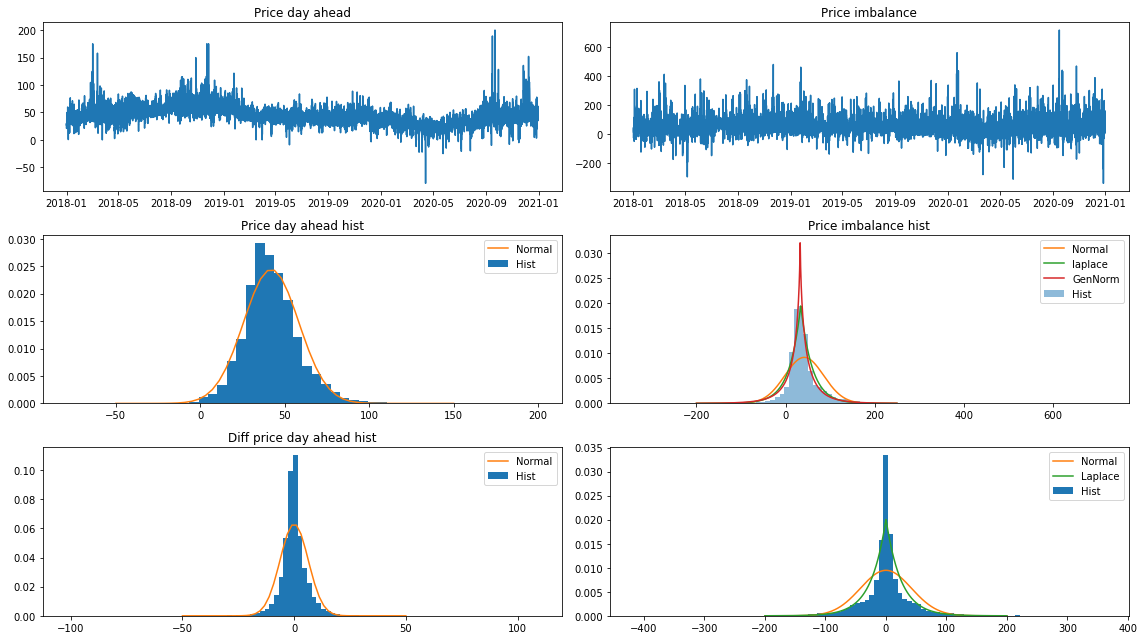

In [49]:
fig1 = plt.figure(figsize = (16,9))
ax1 = fig1.add_subplot(3,2,1)
ax2 = fig1.add_subplot(3,2,2)
ax3 = fig1.add_subplot(3,2,3)
ax4 = fig1.add_subplot(3,2,4)
ax5 = fig1.add_subplot(3,2,5)
ax6 = fig1.add_subplot(3,2,6)

start_date = "2000-02-01"
end_date = "2030-03-02"

df_sub_price = df_sampling_price[(pd.to_datetime(start_date) <= df_sampling_price["date"]) & (df_sampling_price["date"] <= pd.to_datetime(end_date))]

ax1.plot(df_sub_price["date"], df_sub_price["price_da"])
ax1.set_title("Price day ahead")
ax2.plot(df_sub_price["date"], df_sub_price["price_imbalance"])
ax2.set_title("Price imbalance")

# Histogram DA
ax3.hist(df_sub_price["price_da"], bins = 50, density = True, label = "Hist")

# Normal DA
x_da = np.linspace(-50, 150)
mu_da, std_da = norm.fit(df_sub_price["price_da"])
print(f"DA Normal: mu {mu_da:.3f}, std {std_da:.3f}")
pdf_norm_da = norm.pdf(x_da, mu_da, std_da)
ax3.plot(x_da, pdf_norm_da, label = "Normal")
ax3.legend(loc = "upper right")
ax3.set_title("Price day ahead hist")

# Histogram IM
ax4.hist(df_sub_price["price_imbalance"], bins = 100, alpha = 0.5, density = True, label = "Hist")

# Normal IM
x_im = np.linspace(-200, 250, 2000)

#mu_im2 = df_sub_price["price_imbalance"].mean()
#std_im2 = df_sub_price["price_imbalance"].std()
#print(f"IM numpy normal: mu {mu_im2}, std {std_im2}")
mu_im, std_im = norm.fit(df_sub_price["price_imbalance"])
print(f"IM Normal: mu {mu_im:.3f}, std {std_im:.3f}")
pdf_im = norm.pdf(x_im, mu_im, std_im)
ax4.plot(x_im, pdf_im, label = "Normal")

# Laplace IM
res_im = laplace.fit(df_sub_price["price_imbalance"], )
print(res_im)
pdf_laplace_im = laplace.pdf(x_im, res_im[0], res_im[1])
ax4.plot(x_im, pdf_laplace_im, label = "laplace")

# Generalized normal
gennorm_im = gennorm.fit(df_sub_price["price_imbalance"])
print(gennorm_im)
pdf_gennorm_im = gennorm.pdf(x_im, gennorm_im[0], gennorm_im[1], gennorm_im[2])
ax4.plot(x_im, pdf_gennorm_im, label="GenNorm")


ax4.legend(loc = "upper right")
ax4.set_title("Price imbalance hist")

# Diffs
diff_da = np.diff(df_sub_price["price_da"])
diff_im = np.diff(df_sub_price["price_imbalance"])

# DA diff
ax5.hist(diff_da, bins = 100, density=True, label = "Hist")
x_dda = np.linspace(-50, 50)
mu_dda, std_dda = norm.fit(diff_da)
pdf_dda = norm.pdf(x_dda, mu_dda, std_dda)
ax5.plot(x_dda, pdf_dda, label = "Normal")
ax5.set_title("Diff price day ahead hist")
ax5.legend(loc = "upper right")
print(f"Diff DA normal: mu {mu_dda:.3f}, std {std_dda:.3f}")

# IM diff
ax6.hist(diff_im, bins = 100, density = True, label = "Hist")

# IM diff normal
x_dim = np.linspace(-200, 200, 1000)
mu_dim, std_dim = norm.fit(diff_im)
pdf_dim = norm.pdf(x_dim, mu_dim, std_dim)
ax6.plot(x_dim, pdf_dim, label = "Normal")

# IM Laplace diff
res = laplace.fit(diff_im)
pdf_diff_laplace_im = laplace.pdf(x_dim, res[0], res[1])
ax6.plot(x_dim, pdf_diff_laplace_im, label = "Laplace")
ax6.legend(loc = "upper right")
print(f"Diff IM normal: mu {mu_dim:.3f}, std {std_dim:.3f}")
fig1.tight_layout()

## Eyeball test

In [ ]:
steps = 100
x = list(range(steps))
da = np.random.normal(mu_da, std_da, steps)
#im = np.random.normal(mu_im, std_im, steps)
im = np.random.laplace(res_im[0], res_im[1], steps)
da_rw = np.ones(steps)*mu_da
im_rw = np.ones(steps)*mu_im

for i in range(steps-1):
    da_rw[i+1] = da_rw[i] + np.random.normal(0, std_dda)
    im_rw[i+1] = im_rw[i] + np.random.normal(0, std_dim)
    
fig1 = plt.figure(figsize = (16,8))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)
ax3 = fig1.add_subplot(2,2,3)
ax4 = fig1.add_subplot(2,2,4)

ax1.plot(x, da)
ax2.plot(x, im)
ax3.plot(x, da_rw)
ax4.plot(x, im_rw)

## Extra experiment

In [4]:
l_naiveCost = []
l_bestCost = []
l_savings = []
l_installedStorage = []
l_valueFlex = []
l_maxStorage = []

exp = 1
for i in range(10):
    print(i)
    steps = 10 # Previously 25
    price = np.random.normal(100, 10, steps) 
    demand = np.random.normal(100, 10, steps)
    t = np.arange(steps)
    
    if exp == 1:
        best_cost, Z = oracle_flex(price, demand)
    elif exp==2:
        best_cost, Z = oracle_flex(price, demand, max_storage = 1000)
    elif exp==3:
        best_cost, Z = oracle_flex(price, demand, max_storage = 1000, max_ac = 100, max_ad = -100)
    elif exp==4:
        best_cost, Z = oracle_flex(price, demand, max_storage = 100)
    
    naive_cost = np.sum(np.multiply(price, demand))
    storage = np.cumsum(Z - demand)
    installed_storage = max(storage)
    value_flex = (naive_cost - best_cost) / installed_storage
    
    l_naiveCost.append(naive_cost)
    l_bestCost.append(best_cost)
    l_savings.append(naive_cost - best_cost)
    l_installedStorage.append(installed_storage)
    l_valueFlex.append(value_flex)
    #time.sleep(2)

print(f"NaiveCost: {np.mean(l_naiveCost):.3f} +/- {np.std(l_naiveCost):.3f}")
print(f"BestCost: {np.mean(l_bestCost):.3f} +/- {np.std(l_bestCost):.3f}")
print(f"Savings: {np.mean(l_savings):.3f} +/- {np.std(l_savings):.3f}")
print(f"installedStorage: {np.mean(l_installedStorage):.3f} +/- {np.std(l_installedStorage):.3f}")
print(f"valueFlex: {np.mean(l_valueFlex):.3f} +/- {np.std(l_valueFlex):.3f}")

0
1
2
3
4
5
6
7
8
9
NaiveCost: 101169.008 +/- 5203.462
BestCost: 91211.795 +/- 5601.698
Savings: 9957.213 +/- 2902.637
installedStorage: 547.100 +/- 137.431
valueFlex: 18.429 +/- 3.231
